In [1]:
import pandas as pd
pd.set_option("display.max_columns", None)
from IPython.display import HTML
from IPython.display import display
import numpy as np
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy.optimize import curve_fit

from sklearn import preprocessing
from sklearn import metrics
os.chdir("..")
os.getcwd()

from platform import python_version
print(python_version())

import importlib.util

spec_data_pred = importlib.util.spec_from_file_location("data_pred", "src\\data_prep.py")
prep_data = importlib.util.module_from_spec(spec_data_pred)
spec_data_pred.loader.exec_module(prep_data)

spec_plotting_printing = importlib.util.spec_from_file_location("plotting_printing", "src\\plotting_printing.py")
plotting_printing = importlib.util.module_from_spec(spec_plotting_printing)
spec_plotting_printing.loader.exec_module(plotting_printing)

3.8.10


### Purpose of this notebook: 

# PoC for a multidimensional power law approach for training dataset size prediction.

* Using Cifar10 data
* and a standard cnn architecture
* Varying the number of images per class with different number of overall training dataset sizes
* Collect accuracies for each experiment
* Fit a power law with a linear combination as input.

# statistical models considered:

* ### power law: 
    * Just using last epoch
    * Using all epochs
    * ref: Just using overall training dataset size with last epoch


# Data prep

* reading in csv data
* filter to only keep epochs $>10$
* normalize

Please run `cifar10_datasetsize_multidim.py` before running this notebook.


In [2]:
model_type = "powerlaw_all_epochs"

In [3]:
results_from_file = pd.read_csv("csv_files/Cifar10_acc_subsets_thomas_batch_size_512_mixture_design_maximin_subsetsize_45000_20230705.csv")
results_val_from_file = pd.read_csv("csv_files/Cifar10_acc_subsets_thomas_batch_size_512_mixture_design_maximin_subsetsize_45000_val_20230708.csv")
results_4500_from_file = pd.read_csv("csv_files/Cifar10_acc_subsets_jelena_batch_size_512_mixture_design_maximin_subsetsize_4500_20230715.csv")

#prep_data
data_dict = prep_data.prep_data_all_epochs(results_from_file, 
              results_val_from_file, 
              results_4500_from_file, 
              min_epoch = 20)

# the following unacks all dict items into a corresonding variable:
locals().update(data_dict)

['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
\begin{tabular}{lrrrrrrrrrrrrr}
\toprule
{} &  accs &  plane &   car &  bird &    cat &    deer &    dog &    frog &  horse &   ship &  truck &  epochs\_trained &  total\_training\_size \\
\midrule
0 &  0.20 & 145.00 & 31.00 & 97.00 & 496.00 & 1096.00 & 307.00 & 2382.00 &   9.00 & 373.00 &  63.00 &              20 &              4999.00 \\
1 &  0.25 & 145.00 & 31.00 & 97.00 & 496.00 & 1096.00 & 307.00 & 2382.00 &   9.00 & 373.00 &  63.00 &              25 &              4999.00 \\
2 &  0.24 & 145.00 & 31.00 & 97.00 & 496.00 & 1096.00 & 307.00 & 2382.00 &   9.00 & 373.00 &  63.00 &              30 &              4999.00 \\
3 &  0.26 & 145.00 & 31.00 & 97.00 & 496.00 & 1096.00 & 307.00 & 2382.00 &   9.00 & 373.00 &  63.00 &              35 &              4999.00 \\
4 &  0.29 & 145.00 & 31.00 & 97.00 & 496.00 & 1096.00 & 307.00 & 2382.00 &   9.00 & 373.00 &  63.00 &              40 &              4999.00 \\
\

,itterations,accs,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size
0,0,0.7703,95.387190,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,20,45500.0
1,0,0.7833,95.093551,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,25,45500.0
2,0,0.7774,94.994801,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,30,45500.0
3,0,0.7967,94.904114,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,35,45500.0
4,0,0.8035,95.364757,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,40,45500.0


(12, 10800)


,itterations,accs,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size
0,0,0.7703,95.387190,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,20,45500.0
1,0,0.7833,95.093551,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,25,45500.0
2,0,0.7774,94.994801,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,30,45500.0
3,0,0.7967,94.904114,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,35,45500.0
4,0,0.8035,95.364757,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,40,45500.0


In [4]:
"otentially to be deleted "
props = dict(boxstyle='round', facecolor='white', alpha=0.5)


# powerlaw - full linear option

### Full option: 

* Fit a power law model, having the count of each level as input ... 
* ... and the number of epochs as an input as well.

In [5]:
y_hat_name = "accs_hat_classes_linear_epoch_linear"

def func(x, a: float, b: float, c: float, d0:float, d1:float, d2:float, d3:float, d4:float, d5:float, d6:float, d7:float, d8:float, d9:float, d_epochs:float) -> float:
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    x4 = x[4]
    x5 = x[5]
    x6 = x[6]
    x7 = x[7]
    x8 = x[8]
    x9 = x[9]
    epochs_trained = x[10]
    return a + ((d0*x0 + d1*x1 + d2*x2 + d3*x3 + d4*x4 + d5*x5 + d6*x6 + d7*x7 + d8*x8 + d9*x9 + d_epochs*epochs_trained)**b) * c

np.random.seed(seed=4213523)
p0 = np.random.uniform(low=0, high=1, size = 14)
converged = False
try:
    params, params_cov = curve_fit(func, xdata, y, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")

param_name,a,b,c,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epoch
param_value,-0.028546,0.381403,0.455502,0.658278,0.525164,0.516432,0.281976,0.522926,0.472828,0.50151,0.64134,0.380966,0.4241,0.669978


\begin{tabular}{lrrrrrrrrrrrrrr}
\toprule
param\_name &     a &    b &    c &  plane &  car &  bird &  cat &  deer &  dog &  frog &  horse &  ship &  truck &  epoch \\
\midrule
param\_value & -0.03 & 0.38 & 0.46 &   0.66 & 0.53 &  0.52 & 0.28 &  0.52 & 0.47 &  0.50 &   0.64 &  0.38 &   0.42 &   0.67 \\
\bottomrule
\end{tabular}

0.002005015466091406


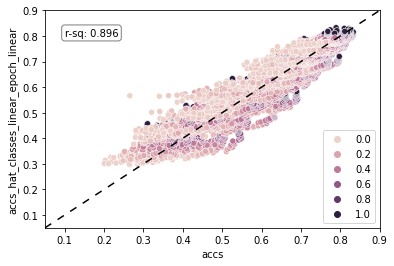

0.8958535485189698
mean val loss: 0.0021504284525420865


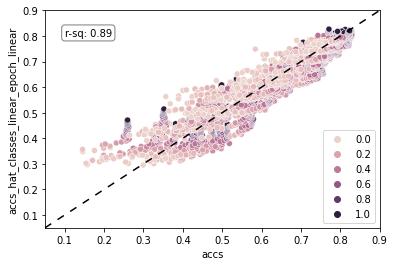

r_square val: 0.8896818108862111


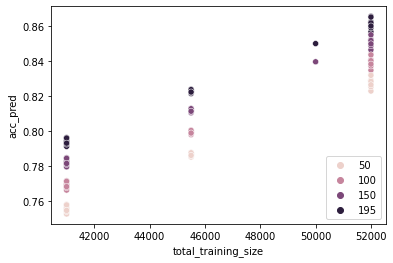

,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size,acc_pred
0,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,195,50000.0,0.849975
1,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,150,50000.0,0.839560
2,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0,0.823757
3,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0,0.812809
4,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0,0.800368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,5000.0,50,52000.0,0.825312
118,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,195,52000.0,0.860039
119,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,150,52000.0,0.849818
120,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,100,52000.0,0.838231


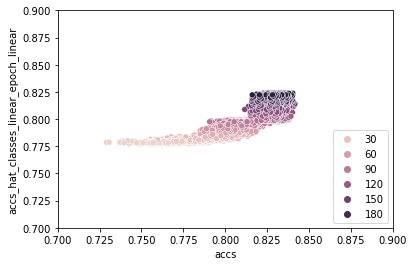

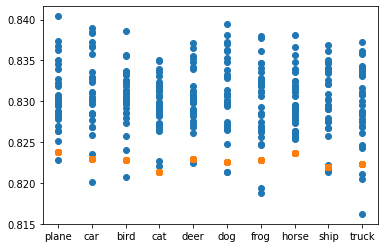

In [6]:
param_names = ["a", "b", "c"]
param_names = param_names + classes + ["epoch"]
if converged:
    plotting_printing.plotting_printing_all_epochs(func, model_type, y_hat_name, xdata, y, param_names,  params, results, xdata_val, y_val, results_val, xdata_4500, xdata_pred, results_pred_orig, results_4500, results_4500_orig, saving_plots=False)

### Using an arctan effect for epoch only, but linear for classes:

In [7]:
y_hat_name = "accs_hat_classes_linear_epoch_arctan"

def func(x, a: float, b: float, c: float, d0:float, d1:float, d2:float, d3:float, d4:float, d5:float, d6:float, d7:float, d8:float, d9:float, d_epochs:float, d_epoch_2:float) -> float:
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    x4 = x[4]
    x5 = x[5]
    x6 = x[6]
    x7 = x[7]
    x8 = x[8]
    x9 = x[9]
    epochs_trained = x[10]
    return a + ((d0*x0 + d1*x1 + d2*x2 + d3*x3 + d4*x4 + d5*x5 + d6*x6 + d7*x7 + d8*x8 + d9*x9 + d_epochs*np.arctan(d_epoch_2 * epochs_trained))**b) * c

np.random.seed(seed=42135230)
p0 = np.random.uniform(low=0, high=1, size = 15)
converged = False
try:
    params, params_cov = curve_fit(func, xdata, y, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")


In [8]:
param_names = ["a", "b", "c"]
param_names = param_names + classes + ["epoch", "epoch_2"]


### using an arctan effect for every class:

In [9]:
y_hat_name = "accs_hat_classes_arctan_epoch_artan"

def func(x, a: float, b: float, c: float, d0:float, d0_2:float, d1:float, d1_2:float, d2:float, d2_2:float, d3:float, d3_2:float, d4:float, d4_2:float, d5:float, d5_2:float, d6:float, d6_2:float, d7:float, d7_2:float, d8:float, d8_2:float, d9:float, d9_2:float, d_epochs:float, d_epoch_2:float) -> float:
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    x4 = x[4]
    x5 = x[5]
    x6 = x[6]
    x7 = x[7]
    x8 = x[8]
    x9 = x[9]
    epochs_trained = x[10]
    return a + ((d0* np.arctan(d0_2 * x0) + d1* np.arctan(d1_2 * x1)  + d2* np.arctan(d2_2 * x2) + d3 * np.arctan(d3_2 * x3) + d4 * np.arctan(d4_2 * x4) + d5 * np.arctan(d5_2 * x5) + d6 * np.arctan(d6_2 * x6) + d7 * np.arctan(d7_2 * x7) + d8 * np.arctan(d8_2 * x8) + d9 * np.arctan(d9_2 * x9) + d_epochs*np.arctan(d_epoch_2 * epochs_trained))**b) * c

np.random.seed(seed=42135230)
n_p = 25
p0 = np.random.uniform(low=0, high=1, size = n_p)
converged = False
try:
    params, params_cov = curve_fit(func, xdata, y, maxfev=200000, p0=p0, bounds=(-10, 50))
    converged = True
except:
    print("did not converge")



param_name,a,b,c,plane_1,plane_2,car_1,car_2,bird_1,bird_2,cat_1,cat_2,deer_1,deer_2,dog_1,dog_2,frog_1,frog_2,horse_1,horse_2,ship_1,ship_2,truck_1,truck_2,epoch_1,epoch_2
param_value,0.151507,1.383827,0.022337,0.736557,9.543433,0.833636,15.662806,0.662435,7.414664,0.447738,6.138,0.700804,4.030193,0.56486,5.308396,0.736686,10.231103,0.837716,12.558595,0.796032,17.630621,0.716979,17.850267,1.062883,8.695603


\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
param\_name &    a &    b &    c &  plane\_1 &  plane\_2 &  car\_1 &  car\_2 &  bird\_1 &  bird\_2 &  cat\_1 &  cat\_2 &  deer\_1 &  deer\_2 &  dog\_1 &  dog\_2 &  frog\_1 &  frog\_2 &  horse\_1 &  horse\_2 &  ship\_1 &  ship\_2 &  truck\_1 &  truck\_2 &  epoch\_1 &  epoch\_2 \\
\midrule
param\_value & 0.15 & 1.38 & 0.02 &     0.74 &     9.54 &   0.83 &  15.66 &    0.66 &    7.41 &   0.45 &   6.14 &    0.70 &    4.03 &   0.56 &   5.31 &    0.74 &   10.23 &     0.84 &    12.56 &    0.80 &   17.63 &     0.72 &    17.85 &     1.06 &     8.70 \\
\bottomrule
\end{tabular}

0.00050135114234363


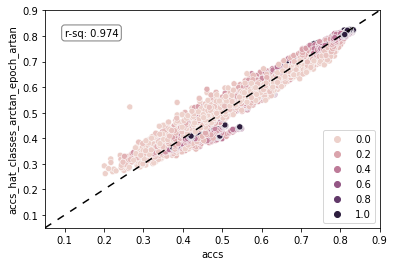

0.9739583343350282
mean val loss: 0.0005784586323472864


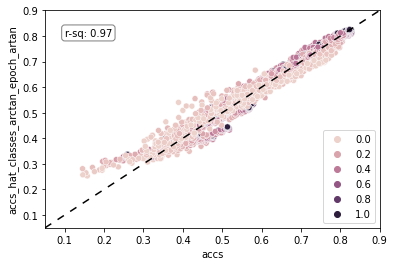

r_square val: 0.9703247468092442


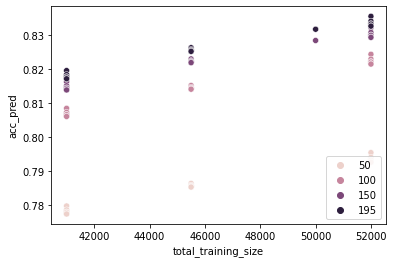

,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size,acc_pred
0,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,195,50000.0,0.831677
1,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,150,50000.0,0.828367
2,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0,0.825484
3,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0,0.822182
4,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0,0.814357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,5000.0,50,52000.0,0.792652
118,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,195,52000.0,0.832590
119,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,150,52000.0,0.829278
120,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,100,52000.0,0.821430


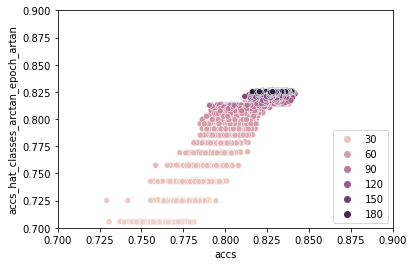

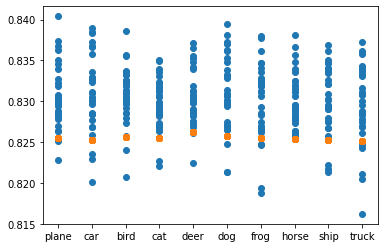

param_value           
param_no           1          2
feature                        
bird        0.662435   7.414664
car         0.833636  15.662806
cat         0.447738   6.138000
deer        0.700804   4.030193
dog         0.564860   5.308396
epoch       1.062883   8.695603
frog        0.736686  10.231103
horse       0.837716  12.558595
plane       0.736557   9.543433
ship        0.796032  17.630621
truck       0.716979  17.850267

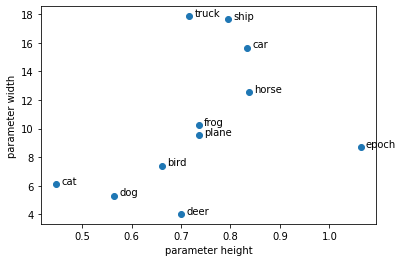

In [10]:
param_names = ["a", "b", "c"]
for c in classes:
    param_names = param_names + [f"{c}_1", f"{c}_2"]
param_names = param_names + ["epoch_1", "epoch_2"]

if converged:
    plotting_printing.plotting_printing_all_epochs(func, model_type, y_hat_name, xdata, y, param_names,  params, results, xdata_val, y_val, results_val, xdata_4500, xdata_pred, results_pred_orig, results_4500, results_4500_orig, saving_plots=False, is_2param=True)


# all class counts linear, but including quadratic term for epoch:

In [11]:
y_hat_name = "accs_hat_classes_linear_epoch_sq"

def func(x, a: float, b: float, c: float, d0:float, d1:float, d2:float, d3:float, d4:float, d5:float, d6:float, d7:float, d8:float, d9:float, d_epochs:float, d_epochs_sq:float) -> float:
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    x4 = x[4]
    x5 = x[5]
    x6 = x[6]
    x7 = x[7]
    x8 = x[8]
    x9 = x[9]
    epochs_trained = x[10]
    return a + ((d0*x0 + d1*x1 + d2*x2 + d3*x3 + d4*x4 + d5*x5 + d6*x6 + d7*x7 + d8*x8 + d9*x9 + d_epochs*epochs_trained + d_epochs_sq * epochs_trained**2)**b) * c

np.random.seed(seed=42132457)
n_p = 15
p0 = np.random.uniform(low=0, high=1, size = n_p)
converged = False
try:
    params, params_cov = curve_fit(func, xdata, y, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")

param_name,a,b,c,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epoch,epoch**2
param_value,-0.170201,0.344375,0.581683,0.5749,0.464166,0.453643,0.251432,0.461768,0.415005,0.442689,0.564878,0.337854,0.374141,1.916812,-1.363855


\begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
param\_name &     a &    b &    c &  plane &  car &  bird &  cat &  deer &  dog &  frog &  horse &  ship &  truck &  epoch &  epoch**2 \\
\midrule
param\_value & -0.17 & 0.34 & 0.58 &   0.57 & 0.46 &  0.45 & 0.25 &  0.46 & 0.42 &  0.44 &   0.56 &  0.34 &   0.37 &   1.92 &     -1.36 \\
\bottomrule
\end{tabular}

0.0018117919986283852


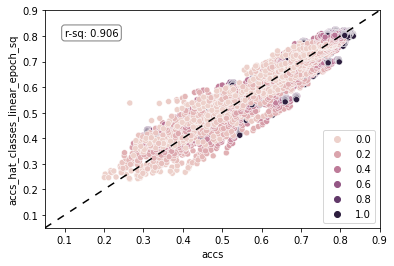

0.9058901486447348
mean val loss: 0.0019466116936647522


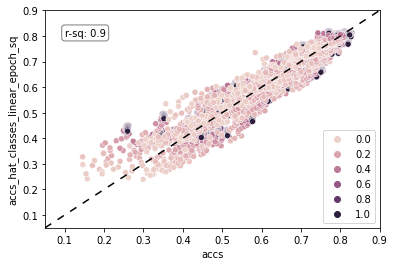

r_square val: 0.9001377252523968


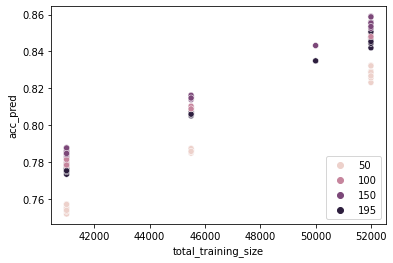

,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size,acc_pred
0,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,195,50000.0,0.834883
1,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,150,50000.0,0.843186
2,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0,0.807510
3,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0,0.816255
4,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0,0.810355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,5000.0,50,52000.0,0.825667
118,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,195,52000.0,0.845365
119,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,150,52000.0,0.853507
120,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,100,52000.0,0.848012


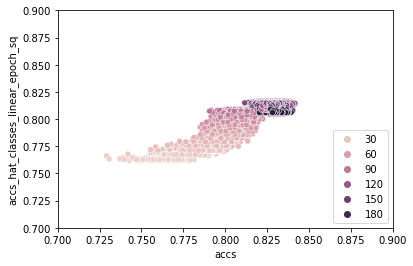

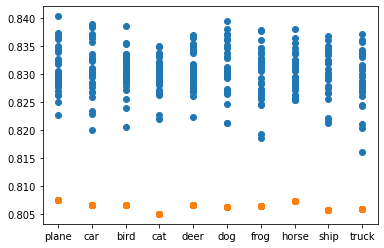

In [12]:
param_names = ["a", "b", "c"]
param_names = param_names + classes + ["epoch", "epoch**2"]

if converged:
    plotting_printing.plotting_printing_all_epochs(func, model_type, y_hat_name, xdata, y, param_names,  params, results, xdata_val, y_val, results_val, xdata_4500, xdata_pred, results_pred_orig, results_4500, results_4500_orig, saving_plots=False, is_2param=False)


# using all epochs, but just overall training dataset size:

In [15]:
#
y_hat_name = "accs_hat_total_n_epoch"

def func(x, a: float, b: float, c: float, d_total_n:float, d_epochs:float) -> float:
    x_epoch = x[10]
    x_total_n = x[11]
    return a + ((d_total_n * x_total_n + d_epochs*x_epoch)**b) * c

np.random.seed(seed=4342133)

p0 = np.random.uniform(low=0, high=1, size = 5)
converged = False
try:
    params, params_cov = curve_fit(func, xdata, y, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")

param_name,a,b,c,total_n,epoch
param_value,0.291628,0.610618,0.504932,0.939217,0.158002


\begin{tabular}{lrrrrr}
\toprule
param\_name &    a &    b &    c &  total\_n &  epoch \\
\midrule
param\_value & 0.29 & 0.61 & 0.50 &     0.94 &   0.16 \\
\bottomrule
\end{tabular}

0.0021267406638585183


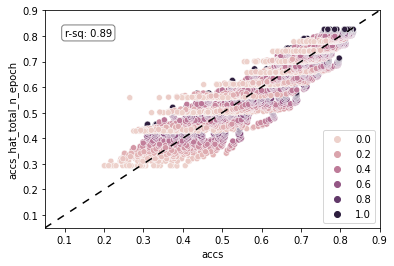

0.8895307806313063
mean val loss: 0.0020191092503302433


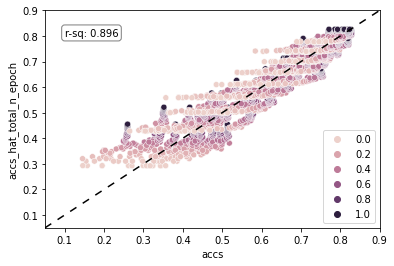

r_square val: 0.896418559819547


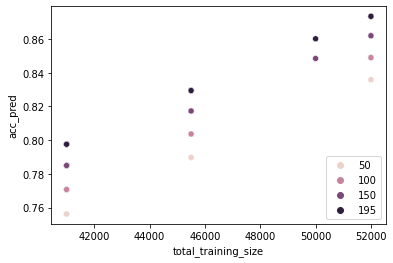

,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size,acc_pred
0,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,195,50000.0,0.860179
1,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,150,50000.0,0.848488
2,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0,0.829447
3,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0,0.817327
4,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0,0.803647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,5000.0,50,52000.0,0.835845
118,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,195,52000.0,0.873501
119,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,150,52000.0,0.861985
120,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,100,52000.0,0.849012


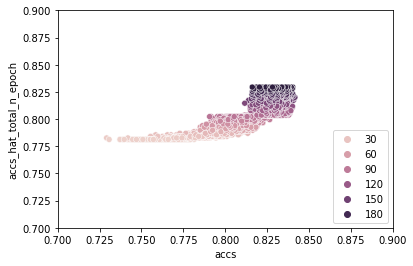

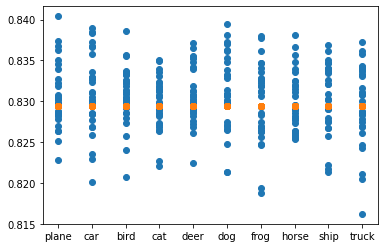

In [16]:
param_names = ["a", "b", "c"]
param_names = param_names + ["total_n", "epoch"]

if converged:
    plotting_printing.plotting_printing_all_epochs(func, model_type, y_hat_name, xdata, y, param_names,  params, results, xdata_val, y_val, results_val, xdata_4500, xdata_pred, results_pred_orig, results_4500, results_4500_orig, saving_plots=False, is_2param=False)


### Using the arctan trick also for the total_n model:

In [18]:
y_hat_name = "accs_hat_total_n_arctan_epoch_arctan"

def func(x, a: float, b: float, c: float, d_total_n:float, d_total_n_2:float, d_epochs:float, d_epochs_2:float) -> float:
    x_epoch = x[10]
    x_total_n = x[11]
    return a + ((d_total_n * np.arctan(d_total_n_2 * x_total_n) + d_epochs* np.arctan( d_epochs_2 * x_epoch))**b) * c

np.random.seed(seed=92548)
n_p = 7
p0 = np.random.uniform(low=0, high=1, size = n_p)
converged = False
try:
    params, params_cov = curve_fit(func, xdata, y, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")

param_name,a,b,c,total_n_1,total_n_2,epoch_1,epoch_2
param_value,0.25865,0.796769,0.65593,0.762347,1.094061,0.118239,7.958574


\begin{tabular}{lrrrrrrr}
\toprule
param\_name &    a &    b &    c &  total\_n\_1 &  total\_n\_2 &  epoch\_1 &  epoch\_2 \\
\midrule
param\_value & 0.26 & 0.80 & 0.66 &       0.76 &       1.09 &     0.12 &     7.96 \\
\bottomrule
\end{tabular}

0.0018443510711440793


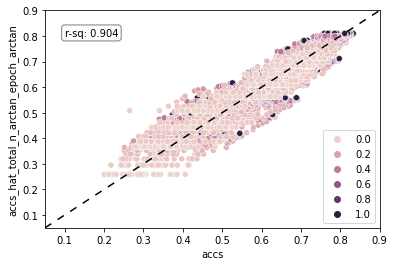

0.9041989338270091
mean val loss: 0.001752802938356856


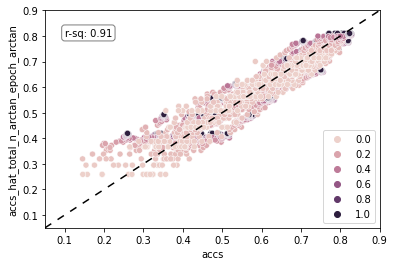

r_square val: 0.9100802234065157


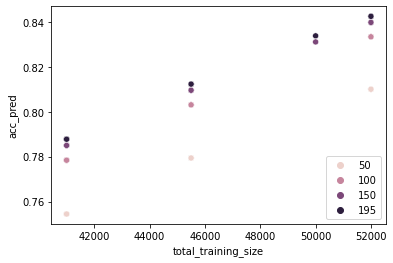

,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size,acc_pred
0,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,195,50000.0,0.833971
1,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,150,50000.0,0.831250
2,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,195,45500.0,0.812433
3,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,150,45500.0,0.809685
4,100.0,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,100,45500.0,0.803171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,5000.0,50,52000.0,0.810142
118,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,195,52000.0,0.842680
119,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,150,52000.0,0.839969
120,100.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,7000.0,100,52000.0,0.833544


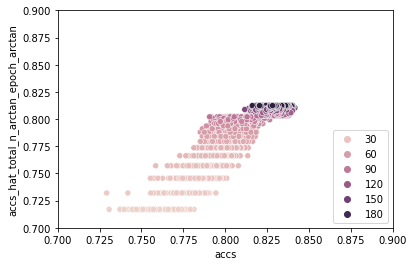

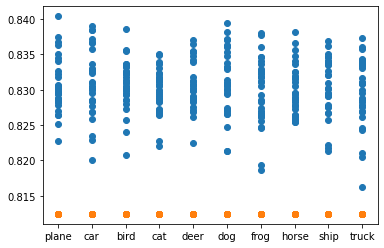

In [19]:
param_names = ["a", "b", "c"]
param_names = param_names + ["total_n_1", "total_n_2", "epoch_1", "epoch_2"]

if converged:
    plotting_printing.plotting_printing_all_epochs(func, model_type, y_hat_name, xdata, y, param_names,  params, results, xdata_val, y_val, results_val, xdata_4500, xdata_pred, results_pred_orig, results_4500, results_4500_orig, saving_plots=False, is_2param=False)
